In [7]:
import requests

response = requests.get('https://services.cancerimagingarchive.net/services/v3/TCIA/query/getSingleImage?SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.7695.4001.306204232344341694648035234440&SOPInstanceUID=1.3.6.1.4.1.14519.5.2.1.7695.4001.254637948180506182312529390348&format=zip')

img = response.content

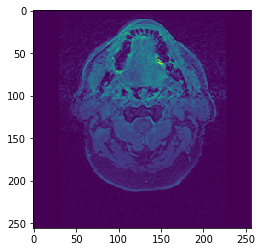

In [12]:
from pydicom import dcmread
from pydicom.filebase import DicomBytesIO
dicom_img = dcmread(DicomBytesIO(img))

from matplotlib import pyplot as pp
pp.imshow(dicom_img.pixel_array)

In [25]:
print(dicom_img.pixel_array.shape)

(256, 256)


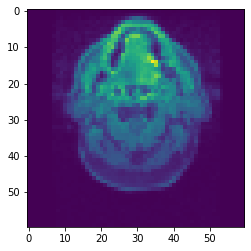

In [38]:
px_data = dicom_img.pixel_array

from skimage.transform import resize

resized_img = resize(px_data, (60, 60), anti_aliasing=True)
pp.imshow(resized_img)

In [39]:
import numpy as np
px_data_scaled = np.maximum(px_data,0) / px_data.max()

px_data_scaled.max()

1.0

In [72]:
response = requests.get('https://services.cancerimagingarchive.net/services/v3/TCIA/query/getSOPInstanceUIDs?SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.7695.4001.306204232344341694648035234440&format=zip')

import json
from tqdm import tqdm

data = json.loads(response.text)
seriesids = [d['sop_instance_uid'] for d in data]

inputs = np.empty((0, 1, 60, 60))

for i in tqdm(seriesids):
    
    response = requests.get(f'https://services.cancerimagingarchive.net/services/v3/TCIA/query/getSingleImage?SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.7695.4001.306204232344341694648035234440&SOPInstanceUID={i}&format=zip')
    
    dicom_img = dcmread(DicomBytesIO(response.content))
    px_data = dicom_img.pixel_array
    px_data = resize(px_data, (60, 60), anti_aliasing=True)
    px_data_scaled = np.maximum(px_data,0) / px_data.max()
    inputs = np.append(inputs, [[px_data_scaled]], axis=0)

print(inputs.shape)
print(inputs)


 54%|███████████████████████████████████████████▊                                     | 67/124 [00:52<00:43,  1.30it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [01:37<00:00,  1.25it/s]

(124, 1, 60, 60)
[[[[0.00254375 0.00254375 0.00254375 ... 0.00254375 0.00254375
    0.00254375]
   [0.00254375 0.00254375 0.00254375 ... 0.00254375 0.00254375
    0.00254375]
   [0.00254375 0.00254375 0.00254375 ... 0.00254375 0.00254375
    0.00254375]
   ...
   [0.00254375 0.00254375 0.00254375 ... 0.00254375 0.00254375
    0.00254375]
   [0.00254375 0.00254375 0.00254375 ... 0.00254375 0.00254375
    0.00254375]
   [0.00254375 0.00254375 0.00254375 ... 0.00254375 0.00254375
    0.00254375]]]


 [[[0.00192693 0.00192693 0.00192693 ... 0.00192693 0.00192693
    0.00192693]
   [0.00192693 0.00192693 0.00192693 ... 0.00192693 0.00192693
    0.00192693]
   [0.00192693 0.00192693 0.00192693 ... 0.00192693 0.00192693
    0.00192693]
   ...
   [0.00192693 0.00192693 0.00192693 ... 0.00192693 0.00192693
    0.00192693]
   [0.00192693 0.00192693 0.00192693 ... 0.00192693 0.00192693
    0.00192693]
   [0.00192693 0.00192693 0.00192693 ... 0.00192693 0.00192693
    0.00192693]]]


 [[[0.0022887

In [239]:
from skimage.color import rgb2gray

def preprocess(px_data):
    #px_data_scaled = px_data / px_data.max()
    px_data = rgb2gray(px_data)
    px_data_scaled = resize(px_data, (60, 60), anti_aliasing=True)
    px_data_scaled = px_data_scaled[None,:,:]
    return px_data_scaled

In [240]:
import pandas as pd 

df = pd.read_pickle("train_csv.pkl")

df = df[df['Image'].map(np.max) != 0]

df['Image'] = df.apply(lambda x: preprocess(x['Image']), axis=1)

In [248]:
inputs = np.asarray(df['Image'].tolist())
print(inputs.shape)
l = df['label'] == 'Alive'
label = l.to_numpy().astype('int')[:, None]
len(label)

(1855, 1, 60, 60)


1855

In [268]:
import torch
from torch.nn import Linear, ReLU, BCELoss, Conv2d, Module, Sigmoid
from torch.optim import Adam
from sklearn.metrics import f1_score, precision_score, recall_score
import time

In [269]:
class Model(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 16, 7)
        self.relu1 = ReLU()
        self.fc1   = Linear(46656, 1)
        self.sigm1 = Sigmoid()
    
    def forward(self, X, debug=False):
        if debug: print(f"Input Shape: {X.shape}")

        X = self.relu1(self.conv1(X))
        if debug: print(f"Conv1 Shape: {X.shape}")

        X = X.view(X.size(0), -1) # Flatten the shape
        if debug: print(f"Flattened Shape: {X.shape}")

        X = self.sigm1(self.fc1(X))
        if debug: print(f"Output Shape: {X.shape}")

        return X
    
    def train(self, train, epochs=35, batch_size=100, dump_rate=5):
        
        loss = BCELoss()
        optimizer = Adam(self.parameters(), lr=0.001)
    
        train_batch = torch.utils.data.DataLoader(train, batch_size)

        start_time = time.perf_counter()

        for epoch in range(epochs):
            epoch_loss = 0.0
            
            for data in train_batch:
                inputs = data['data'].float()
                labels = data['label'].float()
                optimizer.zero_grad()
                outputs = self(inputs)
                loss_size = loss(outputs, labels)
                loss_size.backward()
                optimizer.step()
                epoch_loss += loss_size.item()

            epoch += 1
            if epoch % dump_rate == 0:
                curr_time = time.perf_counter() - start_time
                print(f'[{curr_time:6.1f}/{curr_time/epoch*epochs:6.1f}] Epoch {epoch: <3d} Loss: {epoch_loss / 5000:1.5f}\
                Accuracy: {self.acc(train, batch_size):1.5f} F1 Score: {self.f1score(train, batch_size):1.5f} \
                Recall Score: {self.recall(train, batch_size):1.5f} Precision Score: {self.precision(train, batch_size):1.5f}')
    
        print("Done.")

    def acc(self, test_data, batch_size=100):
        test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
        num_correct = 0
        
        for data in test_dataloader:
            y_pred = self(data["data"].float())
            y_actual = data["label"].float()
            num_correct += (y_pred.round() == y_actual).sum()
            
        return num_correct.item() / len(test_data)
    
    def f1score(self, test_data, batch_size=100):
        test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
        
        ytrue = np.array([])
        ypred = np.array([])

        for data in test_dataloader:
            yp = self(data["data"].float())
            yp_np = yp.round().flatten().detach().numpy()
            ypred = np.append(ypred, yp_np)
            
            yt = data["label"].float()
            yt_np = yt.round().flatten().detach().numpy()
            ytrue = np.append(ytrue, yt_np)
        
        return f1_score(ytrue, ypred)
    
    def precision(self, test_data, batch_size=100):
        test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
        
        ytrue = np.array([])
        ypred = np.array([])

        for data in test_dataloader:
            yp = self(data["data"].float())
            yp_np = yp.round().flatten().detach().numpy()
            ypred = np.append(ypred, yp_np)
            
            yt = data["label"].float()
            yt_np = yt.round().flatten().detach().numpy()
            ytrue = np.append(ytrue, yt_np)
        
        return precision_score(ytrue, ypred)
    
    def recall(self, test_data, batch_size=100):
        test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
        
        ytrue = np.array([])
        ypred = np.array([])

        for data in test_dataloader:
            yp = self(data["data"].float())
            yp_np = yp.round().flatten().detach().numpy()
            ypred = np.append(ypred, yp_np)
            
            yt = data["label"].float()
            yt_np = yt.round().flatten().detach().numpy()
            ytrue = np.append(ytrue, yt_np)
        
        return recall_score(ytrue, ypred)
    
    @staticmethod
    def params_test(a, b, c, d):
        tester = Model()
        X = torch.zeros(a, b, c, d)
        X = tester(X, debug=True)
        print("********All Fine*******")

Model.params_test(100, 1, 60, 60)

Input Shape: torch.Size([100, 1, 60, 60])
Conv1 Shape: torch.Size([100, 16, 54, 54])
Flattened Shape: torch.Size([100, 46656])
Output Shape: torch.Size([100, 1])
********All Fine*******


In [65]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return {'label':self.labels[idx], 'data': self.data[idx]}

In [270]:
datavals = Dataset(torch.as_tensor(inputs), label)

test_no = int(len(datavals)*.1)
train_no = len(datavals) - test_no

train, test = tuple(torch.utils.data.random_split(datavals, [train_no, test_no]))

imgmodel = Model()

imgmodel.train(train, epochs=5, dump_rate=1)



[   4.2/  21.2] Epoch 1   Loss: 0.00175                Accuracy: 0.82335 F1 Score: 0.90274                 Recall Score: 1.00000 Precision Score: 0.82272
[  13.8/  34.4] Epoch 2   Loss: 0.00161                Accuracy: 0.82275 F1 Score: 0.90244                 Recall Score: 1.00000 Precision Score: 0.82222
[  23.1/  38.5] Epoch 3   Loss: 0.00157                Accuracy: 0.82455 F1 Score: 0.90333                 Recall Score: 1.00000 Precision Score: 0.82371
[  32.6/  40.7] Epoch 4   Loss: 0.00155                Accuracy: 0.82635 F1 Score: 0.90423                 Recall Score: 1.00000 Precision Score: 0.82520
[  41.9/  41.9] Epoch 5   Loss: 0.00154                Accuracy: 0.82754 F1 Score: 0.90482                 Recall Score: 1.00000 Precision Score: 0.82619
Done.
Accuracy: 0.81622 Test F1 Score: 0.89820


In [272]:
print(f'Accuracy: {imgmodel.acc(test):1.5f} F1 Score: {imgmodel.f1score(test):1.5f} \
                Recall Score: {imgmodel.recall(test):1.5f} Precision Score: {imgmodel.precision(test):1.5f}')

Accuracy: 0.81622 F1 Score: 0.89820                 Recall Score: 1.00000 Precision Score: 0.81522
